In [1]:
# install libraries
import influxdb_client
import pandas as pd
import secret
import sensor_data_functions
from weather_data_functions import get_current_weather, get_historical_weather
import matplotlib.pyplot as plt
import requests
from datetime import datetime

In [11]:
lookback = '12h'
generation_df, consumption_df = sensor_data_functions.get_sensor_data(lookback)
generation_df.head()

,power
datetime,
2023-12-21 04:25:53+00:00,0.085369
2023-12-21 04:25:54+00:00,0.085176
2023-12-21 04:25:55+00:00,0.085353
2023-12-21 04:25:56+00:00,0.085144
2023-12-21 04:25:57+00:00,0.085491


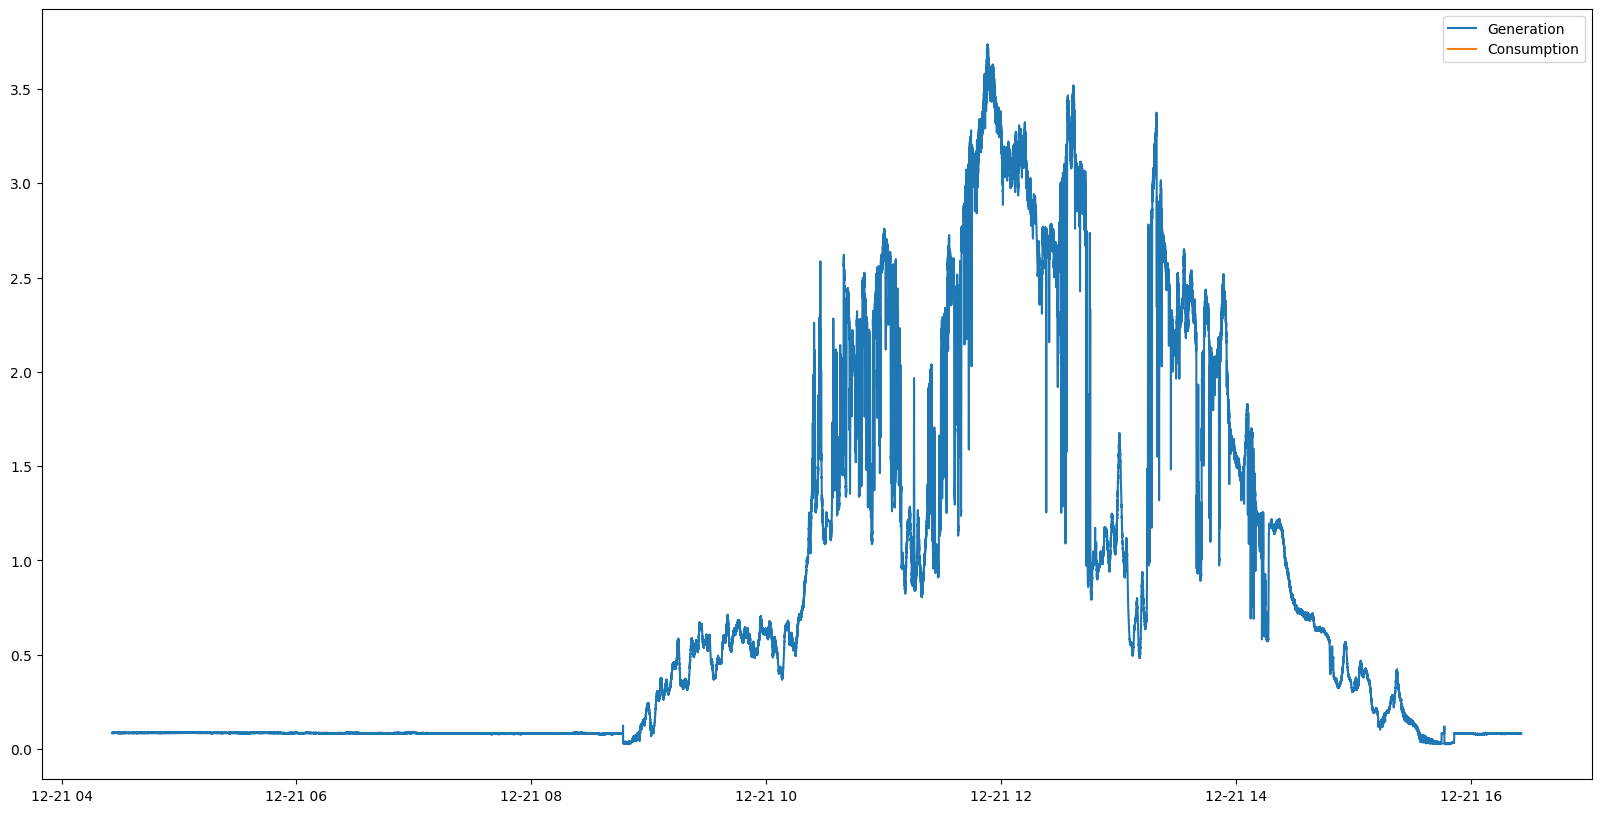

In [12]:
# plot both generation and consumption
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(generation_df.index, generation_df['power'], label='Generation')
ax.plot(consumption_df.index, consumption_df['power'], label='Consumption')
ax.legend()

In [13]:
postcode = 'WR7 4BU'
current_weather = get_current_weather(postcode)
current_weather

,last_updated_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,...,humidity,cloud,feelslike_c,feelslike_f,vis_km,vis_miles,uv,gust_mph,gust_kph,condition
last_updated,,,,,,,,,,,,,,,,,,,,,
2023-12-21 16:15,1703175300,12.0,53.6,0,17.4,28.1,270,W,1009.0,29.8,...,67,50,8.9,47.9,10.0,6.0,1.0,35.5,57.2,Partly cloudy


In [14]:
postcode = 'WR7 4BU'
date_time = datetime(year=2023, month=12, day=21)

weather = get_historical_weather(postcode, date_time)
weather.head()

,time_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,...,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,uv,condition
time,,,,,,,,,,,,,,,,,,,,,
2023-12-21 00:00,1703116800,10.2,50.4,0,18.6,29.9,275,W,1013.0,29.91,...,0,45,0,0,10.0,6.0,27.9,44.9,1.0,Patchy rain possible
2023-12-21 01:00,1703120400,10.2,50.4,0,18.1,29.2,269,W,1012.0,29.88,...,0,45,0,0,10.0,6.0,27.6,44.5,1.0,Patchy rain possible
2023-12-21 02:00,1703124000,10.3,50.5,0,17.9,28.8,272,W,1011.0,29.86,...,0,45,0,0,10.0,6.0,27.0,43.5,1.0,Patchy rain possible
2023-12-21 03:00,1703127600,10.3,50.5,0,19.0,30.6,273,W,1011.0,29.86,...,0,45,0,0,10.0,6.0,28.5,45.8,1.0,Patchy rain possible
2023-12-21 04:00,1703131200,10.5,50.9,0,21.0,33.8,272,W,1010.0,29.83,...,0,0,0,0,10.0,6.0,31.0,50.0,1.0,Overcast


In [15]:
# create code to get irradiance data
lat = 52.2
lon = 0.1
date_time = datetime(year=2023, month=12, day=21)
date_string = date_time.strftime('%Y-%m-%d')

url = f"https://api.openweathermap.org/energy/1.0/solar/data?lat={lat}&lon={lon}&date={date_string}&appid={secret.openweathermap_api_key}"

response = requests.get(url)
weather_data = response.json()
weather_data



{'cod': 401,
 'message': 'Invalid API key. Please see https://openweathermap.org/faq#error401 for more info.'}

In [16]:
url = f"https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={secret.openweathermap_api_key}"

response = requests.get(url)
weather_data = response.json()
weather_data

{'cod': '200',
 'message': 0,
 'cnt': 40,
 'list': [{'dt': 1703181600,
   'main': {'temp': 284.14,
    'feels_like': 283.07,
    'temp_min': 283.16,
    'temp_max': 284.14,
    'pressure': 1006,
    'sea_level': 1006,
    'grnd_level': 1006,
    'humidity': 68,
    'temp_kf': 0.98},
   'weather': [{'id': 803,
     'main': 'Clouds',
     'description': 'broken clouds',
     'icon': '04n'}],
   'clouds': {'all': 60},
   'wind': {'speed': 10.85, 'deg': 299, 'gust': 20.57},
   'visibility': 10000,
   'pop': 0,
   'sys': {'pod': 'n'},
   'dt_txt': '2023-12-21 18:00:00'},
  {'dt': 1703192400,
   'main': {'temp': 283.18,
    'feels_like': 282.07,
    'temp_min': 282.46,
    'temp_max': 283.18,
    'pressure': 1008,
    'sea_level': 1008,
    'grnd_level': 1007,
    'humidity': 70,
    'temp_kf': 0.72},
   'weather': [{'id': 803,
     'main': 'Clouds',
     'description': 'broken clouds',
     'icon': '04n'}],
   'clouds': {'all': 77},
   'wind': {'speed': 9.95, 'deg': 291, 'gust': 17.9},
   '

In [19]:
'''
solar irradiance api details
'''
# convert a postcode to latitude and longitude
postcode = 'WR7 4BU'
url = f"https://api.postcodes.io/postcodes/{postcode}"
response = requests.get(url)
postcode_data = response.json()
postcode_data
lat = postcode_data['result']['latitude']
lon = postcode_data['result']['longitude']

# select the day and interval to get the data for
date_time = datetime(year=2023, month=12, day=21)
date_string = date_time.strftime('%Y-%m-%d')
interval = "15m"

url = f"https://api.openweathermap.org/energy/1.0/solar/interval_data?lat={lat}&lon={lon}&date={date_string}&interval={interval}&appid={secret.openweathermap_api_key}"
response = requests.get(url)
irradiance_data = response.json()
irradiance_data

{'lat': 52.188623,
 'lon': -2.028303,
 'date': '2023-12-21',
 'interval': '15m',
 'tz': '+00:00',
 'sunrise': '2023-12-21T08:14:15',
 'sunset': '2023-12-21T15:57:49',
 'irradiance': {'daily': [{'clear_sky': {'ghi': 938.7,
     'dni': 3287.12,
     'dhi': 376.64},
    'cloudy_sky': {'ghi': 932.96, 'dni': 2920.71, 'dhi': 348.54}}],
  'intervals': [{'start': '00:00',
    'end': '00:15',
    'clear_sky': {'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0},
    'cloudy_sky': {'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}},
   {'start': '00:15',
    'end': '00:30',
    'clear_sky': {'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0},
    'cloudy_sky': {'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}},
   {'start': '00:30',
    'end': '00:45',
    'clear_sky': {'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0},
    'cloudy_sky': {'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}},
   {'start': '00:45',
    'end': '01:00',
    'clear_sky': {'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0},
    'cloudy_sky': {'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}},
   {'start': '01:00',
    'end': '01:15

In [ ]:
'''
create a function to get the irradiance data from local file if it exists, otherwise get it from the api and save it
'''

def get_irradiance_data(lat, lon, date_time, interval):
    date_string = date_time.strftime('%Y-%m-%d')
    url = f"https://api.openweathermap.org/energy/1.0/solar/interval_data?lat={lat}&lon={lon}&date={date_string}&interval={interval}&appid={secret.openweathermap_api_key}"
    response = requests.get(url)
    irradiance_data = response.json()
    return irradiance_data



In [60]:
irradiance_data['irradiance']['intervals'][0]

# put the data into a dataframe
irradiance_df = pd.DataFrame(irradiance_data['irradiance']['intervals'])
irradiance_df.head()

# create new column for the start time of the interval in datetime format
date = irradiance_data['date']
irradiance_df['start_time'] = pd.to_datetime(date + ' ' + irradiance_df['start'])

# save the data to a csv file for future use (so we don't have to keep calling the api)
location = "data/irradiance/"
name = f"irradiance_{lat}_{lon}_{date_string}.csv"
irradiance_df.to_csv(location + name)

In [64]:
'''
create a function to get the irradiance data from local file if it exists, otherwise get it from the api and save it
'''
def api_irradiance_data(lat, lon, date_time, interval='15m'):
    # get the data from the API
    date_string = date_time.strftime('%Y-%m-%d')
    url = f"https://api.openweathermap.org/energy/1.0/solar/interval_data?lat={lat}&lon={lon}&date={date_string}&interval={interval}&appid={secret.openweathermap_api_key}"
    response = requests.get(url)
    irradiance_data = response.json()

    # put the data into a dataframe
    irradiance_df = pd.DataFrame(irradiance_data['irradiance']['intervals'])
    irradiance_df['start_time'] = pd.to_datetime(date_string + ' ' + irradiance_df['start'])

    # save the data to a csv file for future use (so we don't have to keep calling the api)
    location = "data/irradiance/"
    name = f"irradiance_{lat}_{lon}_{date_string}.csv"
    irradiance_df.to_csv(location + name)

    return irradiance_df

In [65]:
date_time = datetime(year=2023, month=12, day=20)
api_irradiance_data(lat, lon, date_time)

,start,end,clear_sky,cloudy_sky,start_time
0,00:00,00:15,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 00:00:00
1,00:15,00:30,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 00:15:00
2,00:30,00:45,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 00:30:00
3,00:45,01:00,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 00:45:00
4,01:00,01:15,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 01:00:00
...,...,...,...,...,...
91,22:45,23:00,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 22:45:00
92,23:00,23:15,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 23:00:00
93,23:15,23:30,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 23:15:00
94,23:30,23:45,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 23:30:00


In [66]:
'''
create a function to see if the data is available locally, if not get it from the api
'''
def irradiance_data(lat, lon, date_time, interval='15m'):
    date_string = date_time.strftime('%Y-%m-%d')
    location = "data/irradiance/"
    name = f"irradiance_{lat}_{lon}_{date_string}.csv"
    try:
        irradiance_df = pd.read_csv(location + name, index_col=0)
        irradiance_df['start_time'] = pd.to_datetime(irradiance_df['start_time'])
        print('Locally available data used')
        return irradiance_df
    except:
        print('No local data available, calling API')
        return api_irradiance_data(lat, lon, date_time, interval)

In [68]:
date_time
irradiance_data(lat, lon, date_time)

Locally available data used


,start,end,clear_sky,cloudy_sky,start_time
0,00:00,00:15,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 00:00:00
1,00:15,00:30,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 00:15:00
2,00:30,00:45,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 00:30:00
3,00:45,01:00,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 00:45:00
4,01:00,01:15,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 01:00:00
...,...,...,...,...,...
91,22:45,23:00,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 22:45:00
92,23:00,23:15,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 23:00:00
93,23:15,23:30,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 23:15:00
94,23:30,23:45,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-20 23:30:00
